In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import nn
from jax import random, device_put
import matplotlib.pyplot as plt

In [2]:
data = np.genfromtxt('../data/winequality-white.csv', delimiter=';', skip_header=1)
data = device_put(data)

In [3]:
Xtrain = data[:3000, :11]
Ytrain = data[:3000, 11]

Xtest = data[3000:, :11]
Ytest = data[3000:, 11]

names = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide",
"density", "pH", "sulphates", "alcohol", "quality"]

In [362]:
# multilayer perceptron with one hidden layers
# this has the following structure:
# y = W2 * sigma(W1 * x + b1) + b2
# lets assume we have input vectors of length 11, a hidden size of 20 and an output size of 1 
# the output is the quality of a wine, which is a continous value, i.e we have a regeression problem
n_in = 11
n_hidden = 50
n_out = 1
# shapes of the weights and biases
key = random.PRNGKey(42)
# W1 shape (in, out) so (11 in, 20 out)
W1 = random.normal(key, (n_in, n_hidden))*jnp.sqrt(2/n_in) # 
b1 = jnp.zeros(n_hidden)
new_key, subkey = random.split(key)
W2 = random.normal(new_key, (n_hidden, n_out)) * jnp.sqrt(2/n_hidden)
b2 = jnp.zeros(n_out)

print("W1:", W1.shape)
print("W2:", W2.shape)

W1: (11, 50)
W2: (50, 1)


In [363]:
# lets turn all we have also into JAX arrays
jXtrain = device_put(Xtrain)
jYtrain = device_put(Ytrain)
jW1 = device_put(W1)
jW2 = device_put(W2)
jb1 = device_put(b1)
jb2 = device_put(b2)

In [5]:
print(jnp.dot(W1.T, Xtrain[0]).shape)
# (20, 11) * (11,)
# what happens which batched inputs?
# W1 * Xbatch
# (11, 20) * (32, 11) does not work, we take Xbatch * W1: (32, 11) * (11, 20)
print(jnp.dot(Xtrain[:5], W1).shape)
# this also works for a single input
print(jnp.dot(Xtrain[0], W1).shape)

(50,)
(5, 50)
(50,)


In [57]:
# forward pass
def forward(x, W1, b1, W2, b2):
    return jnp.dot(nn.relu(jnp.dot(x, W1) + b1), W2) + b2

print("Forward pass:", forward(Xtrain[:5], W1, b1, W2, b2).shape)

def layer(x, W, b):
    return jnp.dot(x, W) + b

def loss(x, y, W1, b1, W2, b2):
    return jnp.mean((forward(x, W1, b1, W2, b2) - y)**2)

print("Loss: ", loss(Xtrain[0], Ytrain[0], W1, b1, W2, b2))

def loss1(x, y, W, b):
    return 1/2*jnp.sum((layer(x, W, b) - y)**2)

y = jnp.dot(nn.relu(jnp.dot(Xtrain[:5], W1) + b1), W2) + b2
jnp.array_equal(y, forward(Xtrain[:5], W1, b1, W2, b2))

# (Nsamples, Nout) + (Nout) works!
foo = np.array(([1, 1], [2, 2])) + np.array([1, 2])
# what happens is that the second array is broadcasted to the first one
# this works because numpy looks at the rightmost dimesions which would be 2 and 1 
# and checks if they are equal or one of them is 1
# in our case the second is 1
# this would not work
# np.array(([1, 1], [2, 2])) + np.array([1, 2, 3])
print(foo)

Forward pass: (5, 1)
Loss:  3981.553
[[2 3]
 [3 4]]


In [9]:
# 2D example
Wfoo = jnp.array(([1.0, 2.0], [3.0, 4.0]))
bfoo = jnp.array([1.0, 2.0])
xfoo = jnp.array([2.0, 2.0])
yfoo = jnp.array([3.0, 3.0])
# loss function without hidden layers
dloss1 = jax.grad(loss1, argnums=(2, 3))
dW, db = dloss1(xfoo, yfoo, Wfoo, bfoo)
print(dW.shape, db.shape)

# lets compare to analytical gradients
dW_ana = np.zeros_like(Wfoo)
for i in range(2):
    for j in range(2):
        dW_ana[i, j] = - (yfoo[j] - layer(xfoo, Wfoo, bfoo)[j]) * xfoo[i]

print("2D Toy:", jnp.array_equal(dW, device_put(dW_ana)))

# in our case 
dW, db = dloss1(Xtrain[0], Ytrain[0], W1, b1)
dW_ana = np.zeros_like(W1)
for i in range(n_in):
    for j in range(n_hidden):
        dW_ana[i, j] = - (Ytrain[0] - layer(Xtrain[0], W1, b1)[j]) * Xtrain[0][i]

print("Wine Problem:", jnp.array_equal(dW, device_put(dW_ana)))

(2, 2) (2,)
2D Toy: True
Wine Problem: True


In [433]:
def update(x, y, W1, b1, W2, b2, lr):
    ypred = forward(x, W1, b1, W2, b2)
    print("ypred: ", ypred.shape)
    h1 = layer(x, W1, b1)
    print("h1: ", h1.shape)
    z1 = nn.relu(h1)
    print("z1: ", z1.shape)
    h2 = layer(z1, W2, b2)
    print("h2: ", h2.shape)

    dy = -2*(y - ypred)[0]
    dW2 = dy*z1.T
    db2 = dy*np.ones_like(b2)
    dsigma = np.diag(np.heaviside(h1, 0.0)[0])
    db1 = dy*np.dot(W2.T, dsigma).reshape(50,)
    dW1 = np.outer(x, dy*np.dot(W2.T, dsigma))
    # also possible
    dW1 = np.dot(x.T, dy*np.dot(W2.T, dsigma))
    # print("dW1", dW1.shape)
    # dW1 = np.dot(x.T, db1.reshape(1, 50))



    # W1 = W1 - lr * dW1
    # b1 = b1 - lr * db1
    # W2 = W2 - lr * dW2
    # b2 = b2 - lr * db2

    return dW1, db1, dW2, db2

    # dW1_ana = np.zeros_like(W1)
    # for i in range(W1.shape[0]):
    #     for j in range(W2.shape[1]):

In [434]:
dW1, db1, dW2, db2 = update(Xtrain[:1], Ytrain[:1], W1, b1, W2, b2, 0.1)
loss(jXtrain[0], jYtrain[0], W1, b1, W2, b2)
dloss = jax.grad(loss, argnums=(2, 3, 4, 5))
jdW1, jdb1, jdW2, jdb2 = dloss(jXtrain[:1], jYtrain[:1], W1, b1, W2, b2)
print(dW2.shape)
print("dW1", dW1.shape, jdW1.shape)
print(jnp.array_equal(jdW1, device_put(dW1)))
print("db1:", db1.shape, jdb1.shape)
print(jnp.array_equal(jdb1, device_put(db1)))
print("dW2: ", dW2.shape, jdW2.shape)
print(jnp.array_equal(jdW2, device_put(dW2)))
print("db2: ", db2.shape, jdb2.shape)
print(jnp.array_equal(jdb2, device_put(db2)))

ypred:  (1, 1)
h1:  (1, 50)
z1:  (1, 50)
h2:  (1, 1)
(50, 1)
dW1 (11, 50) (11, 50)
True
db1: (50,) (50,)
True
dW2:  (50, 1) (50, 1)
True
db2:  (1,) (1,)
True


In [315]:
lossi = []

In [316]:
for _ in range(1000):
    idx = np.random.randint(0, 2999, 1)[0]
    lossi.append(loss(Xtrain[idx:idx+1], Ytrain[idx:idx+1], W1, b1, W2, b2))
    update(Xtrain[idx:idx+1], Ytrain[idx:idx+1], W1, b1, W2, b2, 1e-8)



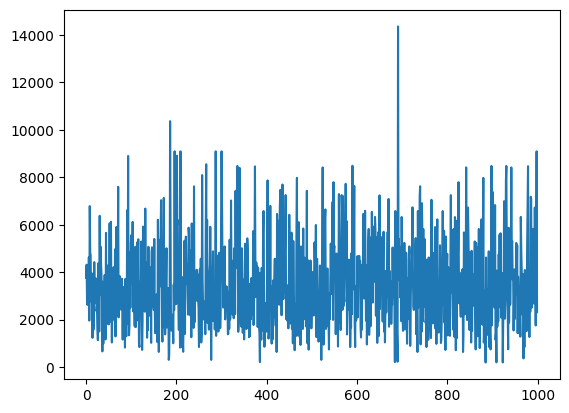

In [317]:
plt.plot(lossi)

In [390]:
xfoo = np.array([1, 2])
np.outer(xfoo, np.array([1]))

array([[1],
       [2]])

In [364]:
lr = 5e-5
lossi = []

In [373]:
for _ in range(10000):
    idx = np.random.randint(0, 3000, 64)
    lossi.append(loss(jXtrain[idx], jYtrain[idx], W1, b1, W2, b2))
    jdW1, jdb1, jdW2, jdb2 = dloss(jXtrain[idx], jYtrain[idx], W1, b1, W2, b2)
    W1 -= lr * jdW1
    W2 -= lr * jdW2
    b1 -= lr * jdb1
    b2 -= lr * jdb2


In [374]:
lossi[-1]

Array(0.7893622, dtype=float32)

In [371]:
Ypred = forward(Xtest, W1, b1, W2, b2)

(0.0, 10.0)

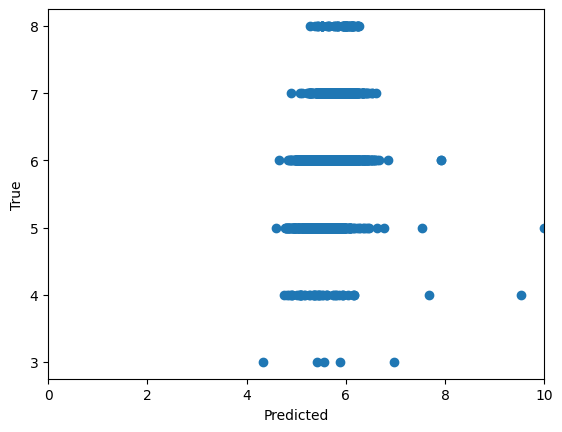

In [372]:
plt.scatter(Ypred, Ytest)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xlim(0, 10)

In [400]:
xfoo = np.array([[1, 2], [3, 4]])
bfoo = np.array([1, 1])

In [401]:
xfoo.shape

(2, 2)

In [402]:
bfoo.shape

(2,)

In [403]:
xfoo + bfoo

array([[2, 3],
       [4, 5]])

In [427]:
xfoo = np.array([1, 1]).reshape(1, 2)
yfoo = np.array([1, 2, 3]).reshape(1, 3)
np.outer(xfoo, yfoo)

array([[1, 2, 3],
       [1, 2, 3]])

In [428]:
np.dot(xfoo.T, yfoo)

array([[1, 2, 3],
       [1, 2, 3]])